In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timezone

from features import SplitFeatures as sf
from features import FeaturePlots as featplot

This notebook examines the difference between temporal and event based splitting of the feature datasets into training and testing datasets. It was used to develop the functions in features.py and the script make_feature_splits.py, which actually writes the datasets split with the event based method to disk. 

In [2]:
p_feats = pd.concat([pd.read_csv('data/features/p_features.csv'), pd.read_csv('data/features/p_features.2022.csv')])
s_feats = pd.concat([pd.read_csv('data/features/s_features.csv'),  pd.read_csv('data/features/s_features.2022.csv')])

In [3]:
ev_cat = pd.read_csv('data/catalogs/yellowstone.events.ypml-v5.2023.csv')
arr_cat = pd.read_csv('data/catalogs/yellowstone.arrivals.2023.csv')
arr_cat = arr_cat[arr_cat['evid'].isin(ev_cat['Evid'].unique())]
ev_cat['Date'] = pd.to_datetime(ev_cat['Date'], format='mixed')

In [4]:
sf.print_feature_df_event_counts(p_feats, "P", ev_cat)
sf.print_feature_df_event_counts(s_feats, "S", ev_cat)

There are 6612 events and 75492 arrivals in the P feature catalog between 2012-10-07 00:32:04.740000+00:00 and 2022-07-27 03:20:04.930000+00:00
There are 5799 events and 14619 arrivals in the S feature catalog between 2012-10-07 00:32:04.740000+00:00 and 2022-07-27 03:20:04.930000+00:00


In [5]:
p_ev = sf.get_feature_event_info(p_feats, ev_cat)
s_ev = sf.get_feature_event_info(s_feats, ev_cat, 'S')

P event count: 6611
S event count: 5798


In [6]:
p_feats = sf.add_YP21_magnitude_to_features(p_feats, p_ev)
s_feats = sf.add_YP21_magnitude_to_features(s_feats, s_ev, 'S')


The original number of P features: 75492 (6612 events) 
The number of P features with a YP21 mag: 75485 (6611 events)
The original number of S features: 14619 (5799 events) 
The number of S features with a YP21 mag: 14617 (5798 events)


# Choose suitable temporal split

In [7]:
train_frac = 0.8

In [8]:
p_ev.iloc[int(p_ev.shape[0]*train_frac)]["Date"]

Timestamp('2020-05-22 08:24:47.320000+0000', tz='UTC')

In [9]:
s_ev.iloc[int(s_ev.shape[0]*train_frac)]["Date"]

Timestamp('2020-07-11 18:38:51.320000+0000', tz='UTC')

2020/7/1 looks like a reasonable temporal cut off based off the entire dataset

In [10]:
train_cutoff = datetime(2020, 7, 1, tzinfo=timezone.utc) #np.datetime64('2020-07-01')

# Do temporal split

In [11]:
p_train_evids, p_test_evids = sf.date_train_test_split(p_ev, train_cutoff)
s_train_evids, s_test_evids = sf.date_train_test_split(s_ev, train_cutoff)
p_train_feats, p_test_feats = sf.get_features_by_evid(p_feats, p_train_evids, p_test_evids)
s_train_feats, s_test_feats = sf.get_features_by_evid(s_feats, s_train_evids, s_test_evids)
sf.print_split_percentage(p_train_evids, p_ev)
sf.print_split_percentage(s_train_evids, s_ev, phase='S')


P Train size: 81.47 %
S Train size: 79.84 %


# Set the minimum training and test sizes for each P and S station
Uses the train_frac variable set above

In [12]:
p_min_train = 150
s_min_train = 150

p_min_test = sf.compute_min_test_examples(p_min_train, train_frac)
s_min_test = sf.compute_min_test_examples(s_min_train, train_frac, phase='S')

P train min: 150, test min: 38, total example min: 188
S train min: 150, test min: 38, total example min: 188


# Look into the number of stations meeting minimum requirements with a temporal split

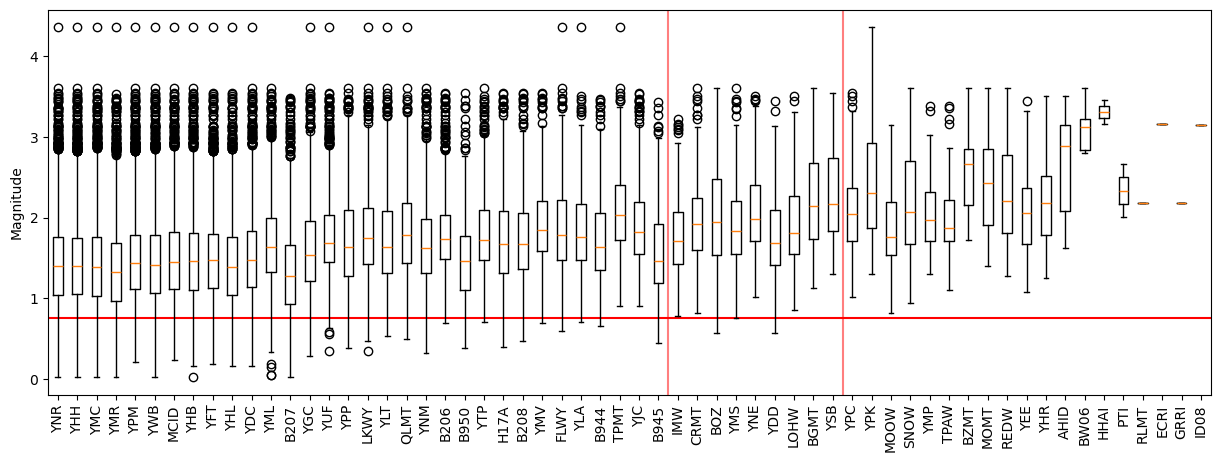

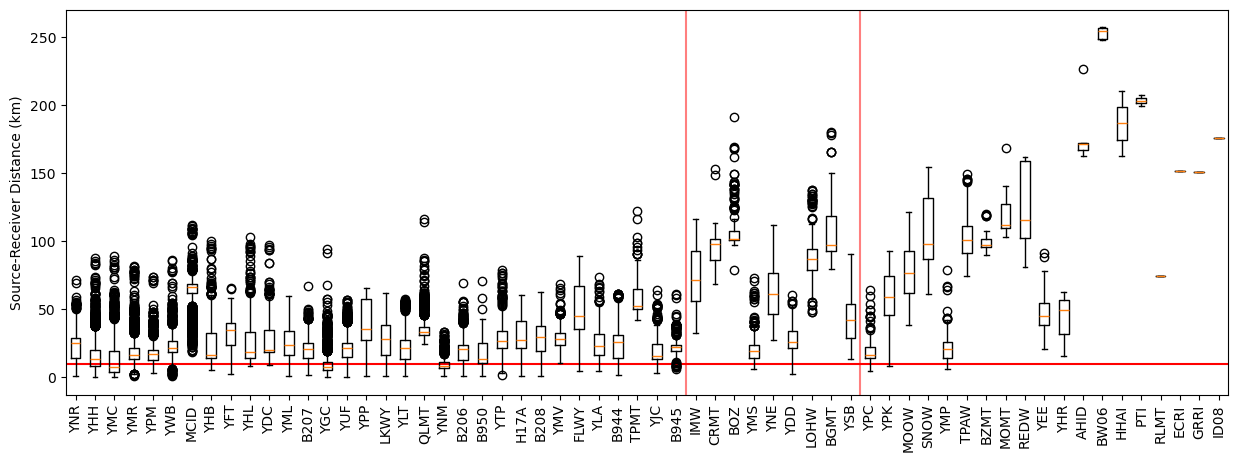

In [13]:
featplot.plot_box_whisker(p_train_feats, "magnitude", "Magnitude", thresholds=[150, 300], min_y_line=0.75)
featplot.plot_box_whisker(p_train_feats, "source_receiver_distance_km", "Source-Receiver Distance (km)", thresholds=[150, 300], min_y_line=10)

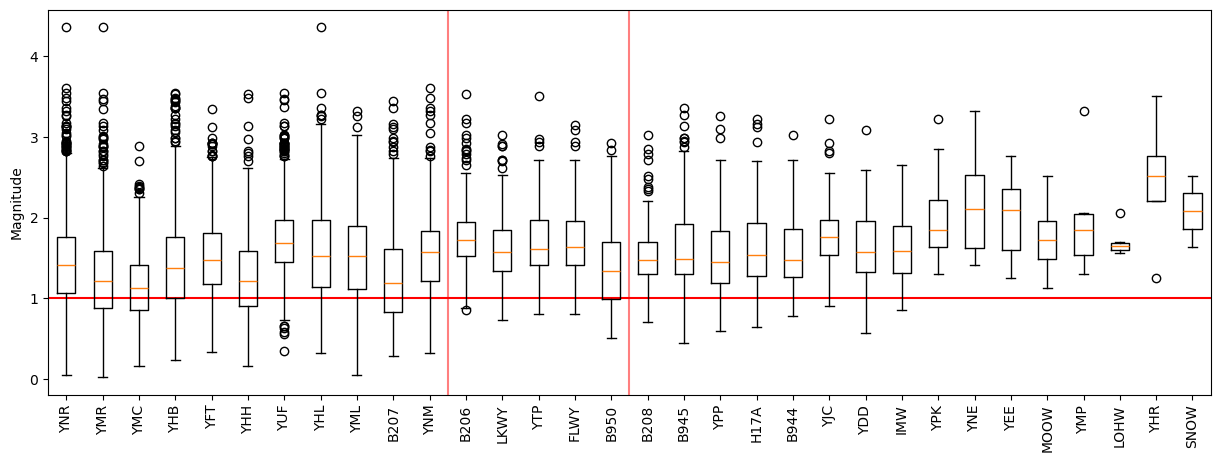

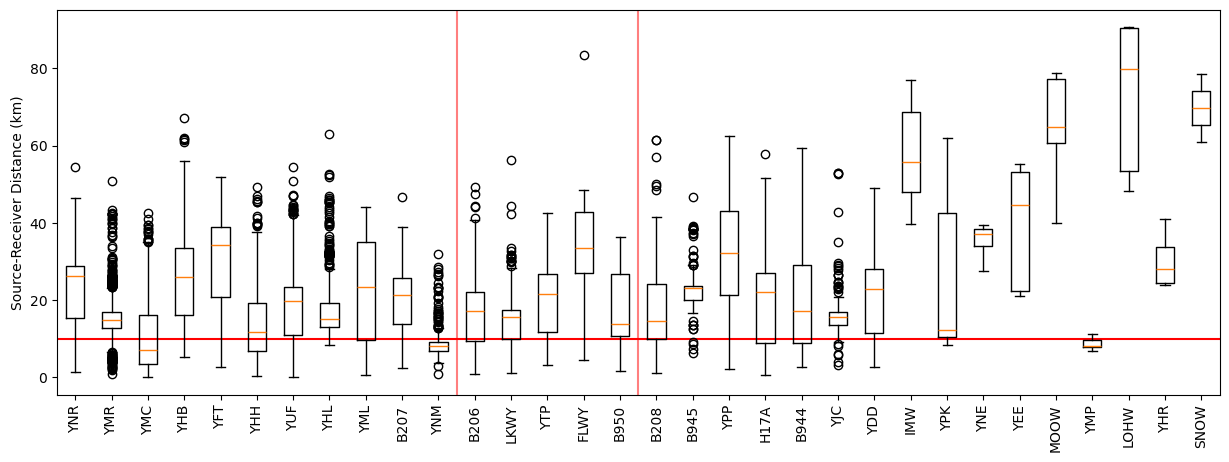

In [14]:
featplot.plot_box_whisker(s_train_feats, "magnitude", "Magnitude", thresholds=[150, 300], min_y_line=1.0)
featplot.plot_box_whisker(s_train_feats, "source_receiver_distance_km", "Source-Receiver Distance (km)", thresholds=[150, 300], min_y_line=10)

In [15]:
p_counts = sf.get_station_train_test_counts(p_train_feats, p_test_feats)
s_counts = sf.get_station_train_test_counts(s_train_feats, s_test_feats)

p_good_stats = sf.get_stations_with_min_examples(p_counts, p_min_train, p_min_test)
s_good_stats = sf.get_stations_with_min_examples(s_counts, s_min_train, s_min_test, 'S')

p_almost_stats = sf.get_stations_close_to_criteria(p_counts, p_min_train, p_min_test)
s_almost_stats = sf.get_stations_close_to_criteria(s_counts, s_min_train, s_min_test, 'S')

P stations meeting the min. criteria: 29
S stations meeting the min. criteria: 11
P stations close to min. criteria: 14
S stations close to min. criteria: 6


In [16]:
p_almost_stats

,station,cnt_train,cnt_test
2,B207,1989,NaN
25,QLMT,979,4.0
1,B206,846,NaN
6,B950,691,NaN
15,H17A,669,NaN
3,B208,660,NaN
4,B944,455,NaN
5,B945,354,NaN
11,CRMT,258,9.0
8,BOZ,251,33.0


In [17]:
sf.get_station_feature_time_span(p_feats, p_almost_stats, ev_cat)

Date,min,max
station,,
B206,2012-10-15 03:20:45.079998+00:00,2016-09-28 08:48:18.650000+00:00
B207,2012-10-07 00:32:04.740000+00:00,2016-09-29 20:49:46.570000+00:00
B208,2012-10-15 02:44:35.520000+00:00,2016-09-27 17:19:50.239998+00:00
B944,2012-10-15 03:22:33.099998+00:00,2016-09-28 08:48:18.650000+00:00
B945,2012-10-15 03:20:45.079998+00:00,2014-09-26 00:31:03.400000+00:00
B950,2014-03-26 19:16:00.870000+00:00,2016-09-28 08:48:18.650000+00:00
BGMT,2012-10-15 02:44:35.520000+00:00,2022-07-10 18:04:17.690000+00:00
BOZ,2012-10-15 02:52:16.060000+00:00,2022-06-23 13:22:06.110000+00:00
CRMT,2012-12-09 22:06:56.930000+00:00,2022-07-27 03:20:04.930000+00:00


In [18]:
sf.get_station_feature_time_span(s_feats, s_almost_stats, ev_cat)

Date,min,max
station,,
B206,2013-01-23 13:41:56.629997+00:00,2016-09-28 08:48:18.650000+00:00
B207,2012-10-07 00:32:04.740000+00:00,2016-09-26 04:46:14.400000+00:00
LKWY,2012-10-20 22:58:15.500000+00:00,2021-11-11 04:09:00.090000+00:00
YDD,2018-10-07 04:44:33.410000+00:00,2022-07-08 11:18:13.310000+00:00
YML,2012-11-03 15:21:00.260000+00:00,2021-11-01 06:39:10.010000+00:00
YPP,2012-10-15 03:16:30.289999+00:00,2022-07-18 21:21:18+00:00


# Do evid split

In [19]:
evid_split_max_time = datetime(2022, 1, 1, tzinfo=timezone.utc)

train_evids, test_evids = sf.evid_train_test_split(pd.concat([p_ev, s_ev]), time_cutoff=evid_split_max_time)
p_train_feats, p_test_feats = sf.get_features_by_evid(p_feats, train_evids, test_evids)
s_train_feats, s_test_feats = sf.get_features_by_evid(s_feats, train_evids, test_evids)
sf.print_split_percentage(p_train_feats['event_identifier'].unique(), p_ev[p_ev['Date'] < evid_split_max_time])
sf.print_split_percentage(s_train_feats['event_identifier'].unique(), s_ev[s_ev['Date'] < evid_split_max_time], phase='S')


P Train size: 80.00 %
S Train size: 79.94 %


In [20]:
_, p_heldout = sf.date_train_test_split(p_ev, evid_split_max_time)
_, s_heldout = sf.date_train_test_split(s_ev, evid_split_max_time)

print(p_heldout.shape[0])
print(s_heldout.shape[0])

197
179


In [21]:
sf.print_split_percentage(p_heldout, p_ev, split_type='2022 held-out')
sf.print_split_percentage(s_heldout, s_ev, phase='S', split_type='2022 held-out')

P 2022 held-out size: 2.98 %
S 2022 held-out size: 3.09 %


# Look into the number of available examples per station when using an evid based split

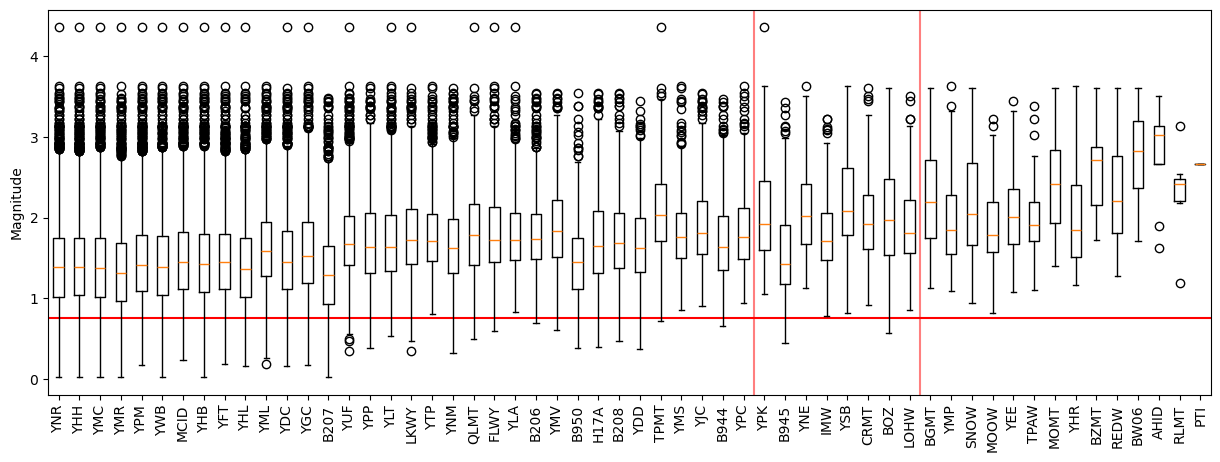

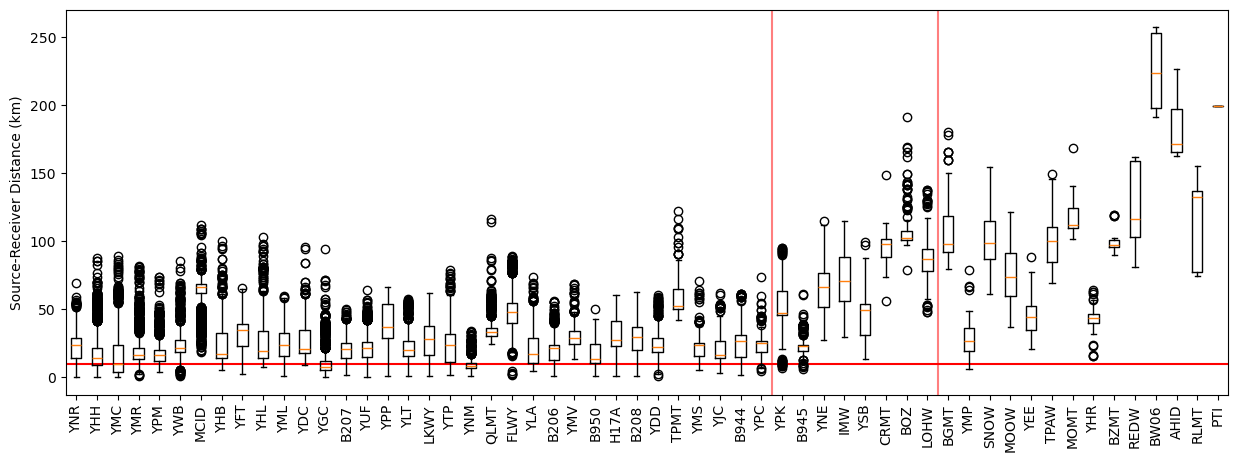

In [22]:
featplot.plot_box_whisker(p_train_feats, "magnitude", "Magnitude", thresholds=[150, 300], min_y_line=0.75)
featplot.plot_box_whisker(p_train_feats, "source_receiver_distance_km", "Source-Receiver Distance (km)", thresholds=[150, 300], min_y_line=10)

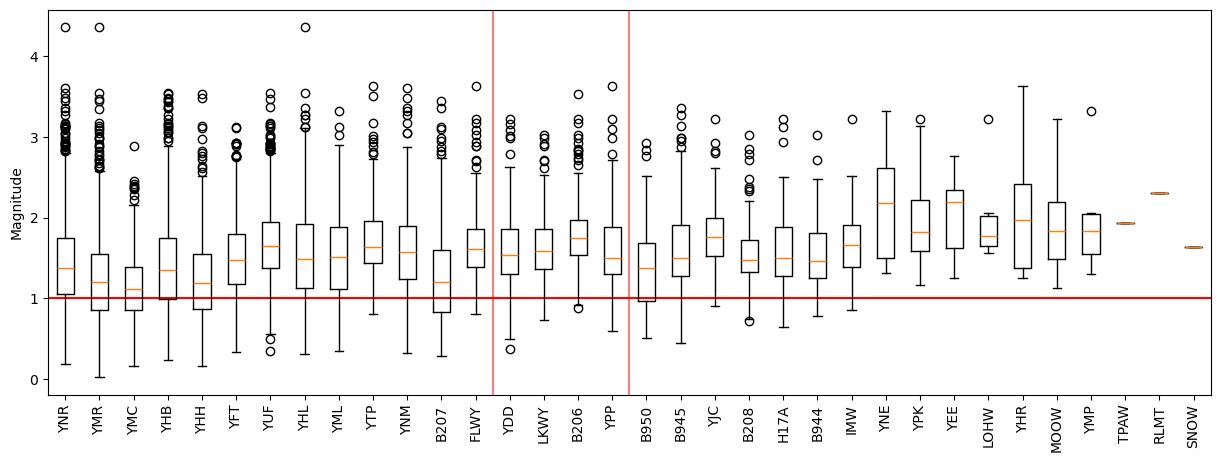

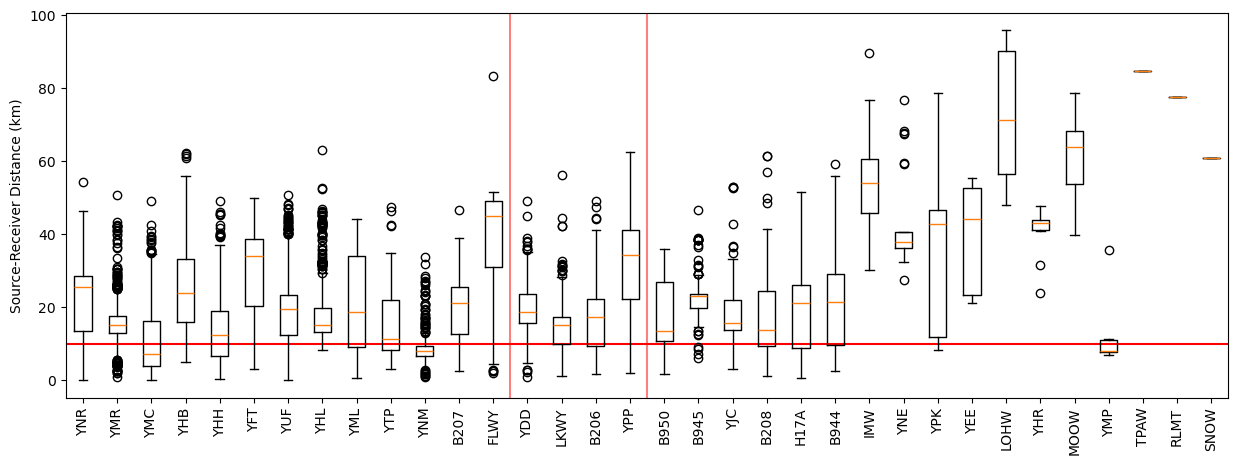

In [23]:
featplot.plot_box_whisker(s_train_feats, "magnitude", "Magnitude", thresholds=[150, 300], min_y_line=1.0)
featplot.plot_box_whisker(s_train_feats, "source_receiver_distance_km", "Source-Receiver Distance (km)", thresholds=[150, 300], min_y_line=10)

In [24]:
p_counts_evid = sf.get_station_train_test_counts(p_train_feats, p_test_feats)
s_counts_evid = sf.get_station_train_test_counts(s_train_feats, s_test_feats)

p_good_stats_evid = sf.get_stations_with_min_examples(p_counts_evid, p_min_train, p_min_test)
s_good_stats_evid = sf.get_stations_with_min_examples(s_counts_evid, s_min_train, s_min_test, 'S')

p_almost_stats_evid = sf.get_stations_close_to_criteria(p_counts_evid, p_min_train, p_min_test)
s_almost_stats_evid = sf.get_stations_close_to_criteria(s_counts_evid, s_min_train, s_min_test, 'S')

P stations meeting the min. criteria: 42
S stations meeting the min. criteria: 17
P stations close to min. criteria: 0
S stations close to min. criteria: 0


In [25]:
s_almost_stats_evid

,station,cnt_train,cnt_test


In [26]:
sf.get_station_feature_time_span(p_feats, p_almost_stats_evid, ev_cat)

,arrival_identifier,avg_noise_1.00,avg_noise_10.00,avg_noise_11.00,avg_noise_12.00,avg_noise_13.00,avg_noise_14.00,avg_noise_15.00,avg_noise_16.00,avg_noise_17.00,...,signal_minimum_value,signal_variance,source_depth_km,source_latitude,source_longitude,source_receiver_back_azimuth,source_receiver_distance_km,station,Evid,Event-Mean-YPML-S
station,,,,,,,,,,,,,,,,,,,,,


In [27]:
sf.get_station_feature_time_span(s_feats, s_almost_stats_evid, ev_cat)

,arrival_identifier,channel1,channel2,event_identifier,location_code,magnitude,magnitude_type,network,radial_avg_noise_1.00,radial_avg_noise_10.00,...,transverse_noise_maximum_value,transverse_noise_minimum_value,transverse_noise_variance,transverse_signal_dominant_amplitude,transverse_signal_dominant_frequency,transverse_signal_maximum_value,transverse_signal_minimum_value,transverse_signal_variance,Evid,Event-Mean-YPML-S
station,,,,,,,,,,,,,,,,,,,,,


I am going to move forward with the event-based train-test split with 2022 heldout in a separate dataset. This method results in the more stations with potentially viable models, which is better for historical catalogs, than just the temporal train-test split at 2020/7/1. Having a small temporal, heldout dataset will allow for a better analysis of the how the method would do in a real-time system. So, this approach strikes a nice balance between building historical earthquake catalogs and developing a method to use for new data. 

In [28]:
p_train_filt = sf.filter_feature_stations(p_train_feats, p_good_stats_evid)
p_test_filt = sf.filter_feature_stations(p_test_feats, p_good_stats_evid)

Original P size: 58265 (56 stations) 
Filtered P size: 57464 (42 stations)
Original P size: 14680 (60 stations) 
Filtered P size: 14465 (42 stations)


In [29]:
s_train_filt = sf.filter_feature_stations(s_train_feats, s_good_stats_evid, phase='S')
s_test_filt = sf.filter_feature_stations(s_test_feats, s_good_stats_evid, phase='S')

Original S size: 11299 (34 stations) 
Filtered S size: 10518 (17 stations)
Original S size: 2851 (31 stations) 
Filtered S size: 2638 (17 stations)
